<a href="https://colab.research.google.com/github/bonareri/Cryptocurrency-Price-Prediction-/blob/main/Copy_of_lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Understanding the Dataset

In [1]:
#Importing necesseray libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import joblib
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input

# Set the Seaborn style for all plots
sns.set_style("darkgrid")

In [144]:
# Define Bitcoin ticker
BTC_TICKER = "BTC-USD"

# Function to fetch historical price data
def fetch_bitcoin_data(ticker, years=5):
    print(f"Fetching Bitcoin data for the last {years} years...")

    crypto = yf.Ticker(ticker)
    df = crypto.history(period=f"{years}y")  # Fetch last `years` of data

    if df.empty:
        print("Error: No historical data found for Bitcoin.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

# Fetch Bitcoin data
btc_df = fetch_bitcoin_data(BTC_TICKER, years=5)

if btc_df is not None:
    # Save full dataset
    btc_df.to_csv("bitcoin_prices_full.csv", index=False)
    print("Full Bitcoin data saved.")

    # Extract last 30 days
    last_30_days = btc_df.tail(30)
    last_30_days.to_csv("bitcoin_last_30_days.csv", index=False)
    print("Last 30 days of Bitcoin data saved.")

Fetching Bitcoin data for the last 5 years...
Full Bitcoin data saved.
Last 30 days of Bitcoin data saved.


In [212]:
# Load the Bitcoin dataset
df = pd.read_csv("bitcoin_prices_full.csv")

# Convert 'Date' column to datetime
df["Date"] = pd.to_datetime(df["Date"])

In [213]:
# Ensure data is sorted by date
df = df.sort_values(by="Date")

# Display basic info
print(df.info())  # Check data types and missing values
print(df.head())  # Preview first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1827 non-null   datetime64[ns]
 1   Close   1827 non-null   float64       
 2   High    1827 non-null   float64       
 3   Low     1827 non-null   float64       
 4   Open    1827 non-null   float64       
 5   Volume  1827 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 85.8 KB
None
        Date        Close         High          Low         Open       Volume
0 2020-03-19  6191.192871  6329.735840  5236.968750  5245.416504  51000731797
1 2020-03-20  6198.778320  6844.261719  5865.781738  6191.653809  54442976103
2 2020-03-21  6185.066406  6378.135254  5932.823242  6206.521484  42494390880
3 2020-03-22  5830.254883  6359.697266  5823.713867  6185.558105  40099664740
4 2020-03-23  6416.314941  6443.934570  5785.004395  5831.374512  46491916000

In [214]:
# Set Date as index
df.set_index("Date", inplace=True)

# Check the first few rows
print(df.head())

                  Close         High          Low         Open       Volume
Date                                                                       
2020-03-19  6191.192871  6329.735840  5236.968750  5245.416504  51000731797
2020-03-20  6198.778320  6844.261719  5865.781738  6191.653809  54442976103
2020-03-21  6185.066406  6378.135254  5932.823242  6206.521484  42494390880
2020-03-22  5830.254883  6359.697266  5823.713867  6185.558105  40099664740
2020-03-23  6416.314941  6443.934570  5785.004395  5831.374512  46491916000


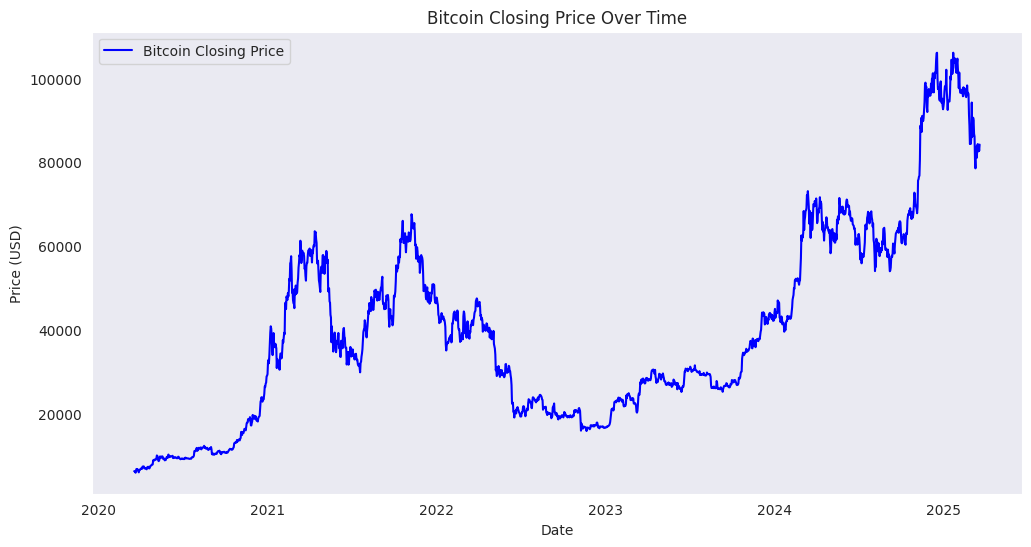

In [215]:
# Plot the closing price trend
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Bitcoin Closing Price", color="blue")  # Use df.index instead of df["Date"]
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Closing Price Over Time")
plt.legend()
plt.grid()
plt.show()

## Feature Engineering

### The Exponential Moving Average (EMA)
- gives more weight to recent prices, making it more responsive than the Simple Moving Average (SMA)

In [216]:
# Calculate Exponential Moving Averages (EMA)
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()  # Short-term trend
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()  # Medium-term trend
df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()  # Long-term trend

# Drop NaN values caused by shifting
df.dropna(inplace=True)

# Display the first few rows to verify
print(df.head())

                  Close         High          Low         Open       Volume  \
Date                                                                          
2020-03-19  6191.192871  6329.735840  5236.968750  5245.416504  51000731797   
2020-03-20  6198.778320  6844.261719  5865.781738  6191.653809  54442976103   
2020-03-21  6185.066406  6378.135254  5932.823242  6206.521484  42494390880   
2020-03-22  5830.254883  6359.697266  5823.713867  6185.558105  40099664740   
2020-03-23  6416.314941  6443.934570  5785.004395  5831.374512  46491916000   

                 EMA_10       EMA_20       EMA_50  
Date                                               
2020-03-19  6191.192871  6191.192871  6191.192871  
2020-03-20  6192.572044  6191.915295  6191.490340  
2020-03-21  6191.207382  6191.263020  6191.238421  
2020-03-22  6125.579655  6156.881292  6177.082204  
2020-03-23  6178.440616  6181.589259  6186.463880  


### Lagging values

In [217]:
# Create lag features for Close price
lags = [1, 2, 3]  # Using 1-day, 2-day, and 3-day lags

for lag in lags:
    df[f"Close_Lag{lag}"] = df["Close"].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)

# Display the first few rows to verify
print(df.head())

                  Close         High          Low         Open       Volume  \
Date                                                                          
2020-03-22  5830.254883  6359.697266  5823.713867  6185.558105  40099664740   
2020-03-23  6416.314941  6443.934570  5785.004395  5831.374512  46491916000   
2020-03-24  6734.803711  6789.022949  6411.066406  6436.642578  48221910672   
2020-03-25  6681.062988  6892.511230  6536.926270  6738.716797  44590107888   
2020-03-26  6716.440430  6735.463867  6590.962891  6675.170898  35319797642   

                 EMA_10       EMA_20       EMA_50   Close_Lag1   Close_Lag2  \
Date                                                                          
2020-03-22  6125.579655  6156.881292  6177.082204  6185.066406  6198.778320   
2020-03-23  6178.440616  6181.589259  6186.463880  5830.254883  6185.066406   
2020-03-24  6279.597543  6234.276350  6207.967402  6416.314941  5830.254883   
2020-03-25  6352.591260  6276.827458  6226.520170  

### Relative Strength Index (RSI)
- The Relative Strength Index (RSI) is a momentum indicator that measures the speed and change of price movements.
- It helps identify overbought and oversold conditions.



In [218]:
# Function to calculate RSI
def calculate_rsi(df, window=14):
    delta = df["Close"].diff(1)  # Price changes

    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss  # Relative Strength
    rsi = 100 - (100 / (1 + rs))  # RSI formula

    return rsi

# Add RSI feature
df["RSI_14"] = calculate_rsi(df, window=14)

# Drop NaN values caused by RSI calculation
df.dropna(inplace=True)

# Display the first few rows to verify
print(df[["Close", "RSI_14"]].head())

                  Close     RSI_14
Date                              
2020-04-04  6867.527344  68.172108
2020-04-05  6791.129395  66.394818
2020-04-06  7271.781250  65.140926
2020-04-07  7176.414551  58.486344
2020-04-08  7334.098633  62.067177


### Bollinger Bands (BB)
Bollinger Bands help detect volatility and price breakouts.

📌 Why use Bollinger Bands?
- Price above upper band → Market might be overbought (sell signal).
- Price below lower band → Market might be oversold (buy signal).
- Bands widening → High volatility (big price movement).
- Bands narrowing → Low volatility (potential breakout).

In [219]:
# Bollinger Bands Calculation
def calculate_bollinger_bands(df, window=20, num_std=2):
    df["BB_Middle"] = df["Close"].rolling(window=window).mean()  # Moving Average
    df["BB_Upper"] = df["BB_Middle"] + (df["Close"].rolling(window=window).std() * num_std)
    df["BB_Lower"] = df["BB_Middle"] - (df["Close"].rolling(window=window).std() * num_std)
    return df

# Apply Bollinger Bands
df = calculate_bollinger_bands(df)

# Drop NaN values caused by BB calculation
df.dropna(inplace=True)

# Display the first few rows to verify
print(df[["Close", "BB_Middle", "BB_Upper", "BB_Lower"]].head())

                  Close    BB_Middle     BB_Upper     BB_Lower
Date                                                          
2020-04-23  7429.724609  7036.878809  7474.427000  6599.330617
2020-04-24  7550.900879  7071.047485  7556.969029  6585.125942
2020-04-25  7569.936035  7109.987817  7625.388010  6594.587625
2020-04-26  7679.867188  7130.392114  7702.007761  6558.776467
2020-04-27  7795.601074  7161.351440  7805.883327  6516.819554


### Moving Average Convergence Divergence (MACD)
- The MACD (Moving Average Convergence Divergence) is a trend-following momentum indicator that shows the relationship between two moving averages of an asset’s price.

In [220]:
# MACD Calculation
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    df["MACD"] = df["Close"].ewm(span=short_window, adjust=False).mean() - df["Close"].ewm(span=long_window, adjust=False).mean()
    df["MACD_Signal"] = df["MACD"].ewm(span=signal_window, adjust=False).mean()
    return df

# Apply MACD
df = calculate_macd(df)

# Drop NaN values caused by MACD calculation
df.dropna(inplace=True)

# Display the first few rows to verify
print(df[["Close", "MACD", "MACD_Signal"]].head())

                  Close       MACD  MACD_Signal
Date                                           
2020-04-23  7429.724609   0.000000     0.000000
2020-04-24  7550.900879   9.666483     1.933297
2020-04-25  7569.936035  18.648253     5.276288
2020-04-26  7679.867188  34.242173    11.069465
2020-04-27  7795.601074  55.301741    19.915920


### Splitting Data

In [221]:
# Define the number of test days
test_days = 60

# Split the data
train_df = df.iloc[:-test_days]  # All but the last 60 days
test_df = df.iloc[-test_days:]   # Last 60 days

# Print sizes
print("Training Data Size:", train_df.shape)
print("Testing Data Size:", test_df.shape)

Training Data Size: (1732, 17)
Testing Data Size: (60, 17)


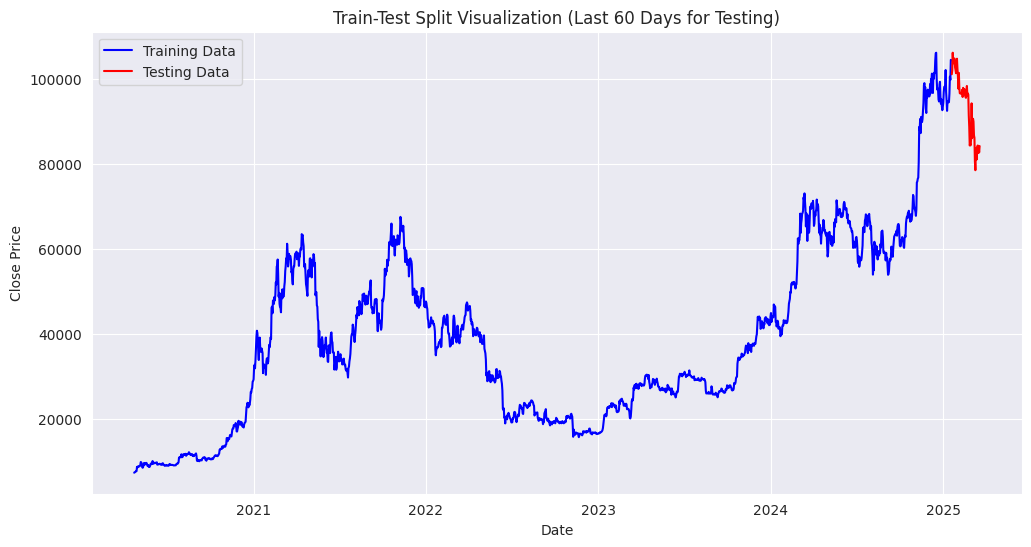

In [222]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Close'], label="Training Data", color='blue')
plt.plot(test_df.index, test_df['Close'], label="Testing Data", color='red')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Train-Test Split Visualization (Last 60 Days for Testing)")
plt.legend()
plt.show()

### Test Set

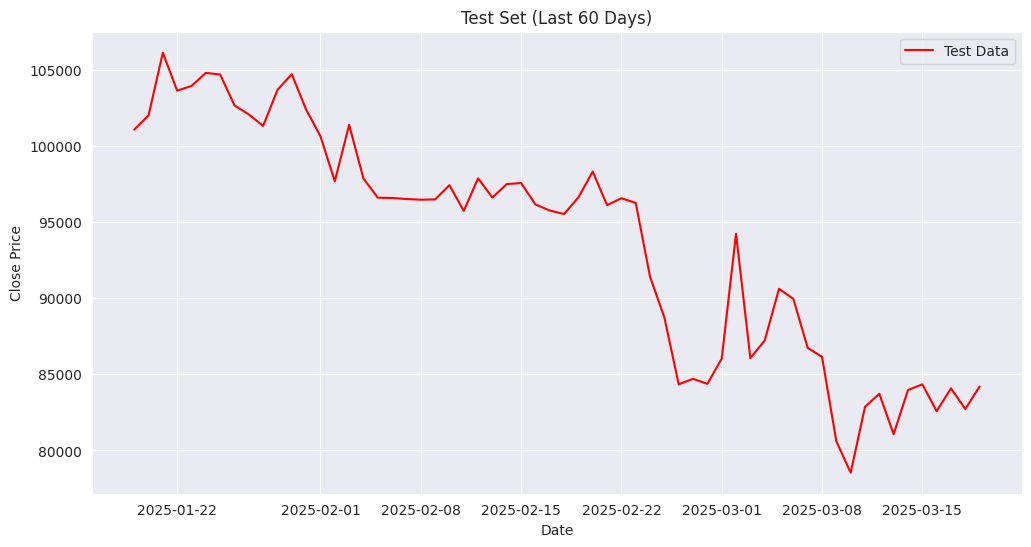

In [223]:
# Plot the test data
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['Close'], label="Test Data", color='red')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Test Set (Last 60 Days)")
plt.legend()
plt.show()

### Separate Features and Target

In [224]:
# Select only the features you want
feature_cols = ["Close_Lag1", "Close_Lag2", "Close_Lag3",
                "EMA_10", "EMA_20", "EMA_50",
                "RSI_14", "BB_Middle", "BB_Upper", "BB_Lower",
                "MACD", "MACD_Signal"]

# Create X (features) and y (target)
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]
y_train = train_df["Close"]
y_test = test_df["Close"]

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1732, 12)
y_train shape: (1732,)
X_test shape: (60, 12)
y_test shape: (60,)


### Feature Scaling

In [225]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features (X)
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (y)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convert scaled data back to DataFrame (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

### Reshape
LSTMs expect input in the form of (samples, timesteps, features):

- Samples → Number of data points
- Timesteps → Number of past days used for prediction
- Features → Number of input features

In [226]:
# Reshape into (samples, timesteps, features)
X_train_lstm = np.reshape(X_train_scaled.values, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled.values, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Verify shape
print(f"X_train shape: {X_train_lstm.shape}")  # Expected: (1732, 1, 12)
print(f"X_test shape: {X_test_lstm.shape}")    # Expected: (60, 1, 12)


X_train shape: (1732, 1, 12)
X_test shape: (60, 1, 12)


### Define Sequences for LSTM

In [227]:
def create_sequences(X, y, lookback=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i : i + lookback])  # Take 5-day sequences
        y_seq.append(y[i + lookback])  # Target is the next day's price
    return np.array(X_seq), np.array(y_seq)

# Apply function with lookback = 5
lookback = 5
X_train_seq, y_train_seq = create_sequences(X_train_scaled.values, y_train_scaled, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled.values, y_test_scaled, lookback)

# Verify new shapes
print("X_train_seq shape:", X_train_seq.shape)  # (samples, 5, features)
print("y_train_seq shape:", y_train_seq.shape)  # (samples, 1)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

X_train_seq shape: (1727, 5, 12)
y_train_seq shape: (1727, 1)
X_test_seq shape: (55, 5, 12)
y_test_seq shape: (55, 1)


### Define the LSTM Model

In [228]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (lookback, X_train_seq.shape[2])  # (timesteps, features)

# Input layer
inputs = Input(shape=input_shape, name="input_layer")

# First LSTM layer (Bidirectional for richer patterns)
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = Dropout(0.3)(x)  # Regularization

# Second LSTM layer (Smaller size for efficiency)
x = LSTM(32)(x)
x = Dropout(0.2)(x)

# Fully connected layers
x = Dense(16, activation="relu")(x)
outputs = Dense(1)(x)  # Final output layer

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile model with a custom learning rate
optimizer = Adam(learning_rate=0.0005)  # Slightly higher LR for faster convergence
model.compile(optimizer=optimizer, loss="mse")

# Show summary
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5, 12)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 5, 128)              │          39,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,577 (236.63 KB)

 Trainable params: 60,577 (236.63 KB)

 Non-trainable params: 0 (0.00 B)

###  Train the Model

In [229]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,  # Adjust as needed
    batch_size=64,  # Adjust for memory usage
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0586 - val_loss: 0.0284
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

### Training Loss Curve

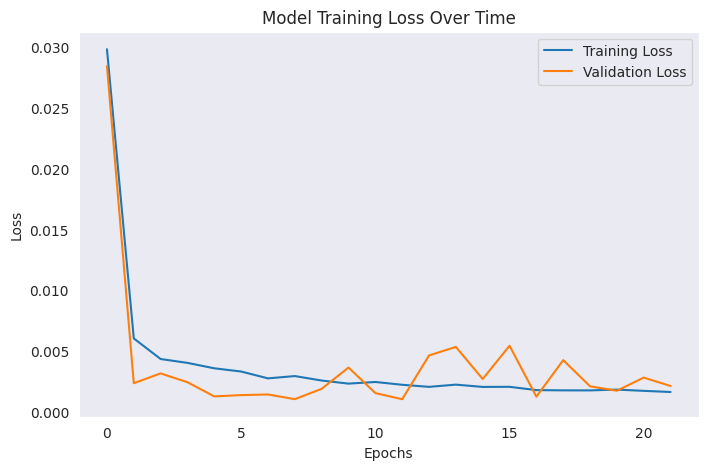

In [230]:
# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training Loss Over Time')
plt.legend()
plt.grid()
plt.show()

### Predictions on the Test Set

In [231]:
# Make predictions
y_pred_scaled = model.predict(X_test_seq)

# Inverse transform predictions and actual values to get real prices
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Assuming `scaler_y` was used for `y_train`
y_test_actual = scaler_y.inverse_transform(y_test_seq)  # Convert y_test back to original scale

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


In [232]:
# Extract test set dates (align with y_test_seq length)
test_dates = df.index[-len(y_test_seq):]

# Create a DataFrame to compare actual and predicted prices
df_comparison = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": y_test_actual.ravel(),
    "Predicted Price": y_pred.ravel()
})

# Calculate the difference (error)
df_comparison["Difference"] = df_comparison["Actual Price"] - df_comparison["Predicted Price"]

# Display the last 15 rows
print(df_comparison.tail(15))

         Date  Actual Price  Predicted Price   Difference
40 2025-03-05  90623.562500     85488.234375  5135.328125
41 2025-03-06  89961.726562     86062.117188  3899.609375
42 2025-03-07  86742.671875     86281.984375   460.687500
43 2025-03-08  86154.593750     86339.203125  -184.609375
44 2025-03-09  80601.039062     86221.828125 -5620.789062
45 2025-03-10  78532.000000     85600.812500 -7068.812500
46 2025-03-11  82862.210938     84644.648438 -1782.437500
47 2025-03-12  83722.359375     83844.085938  -121.726562
48 2025-03-13  81066.703125     83129.570312 -2062.867188
49 2025-03-14  83969.101562     82367.179688  1601.921875
50 2025-03-15  84343.109375     82055.304688  2287.804688
51 2025-03-16  82579.687500     81862.632812   717.054688
52 2025-03-17  84075.687500     81183.984375  2891.703125
53 2025-03-18  82718.500000     81390.695312  1327.804688
54 2025-03-19  84199.335938     81369.648438  2829.687500


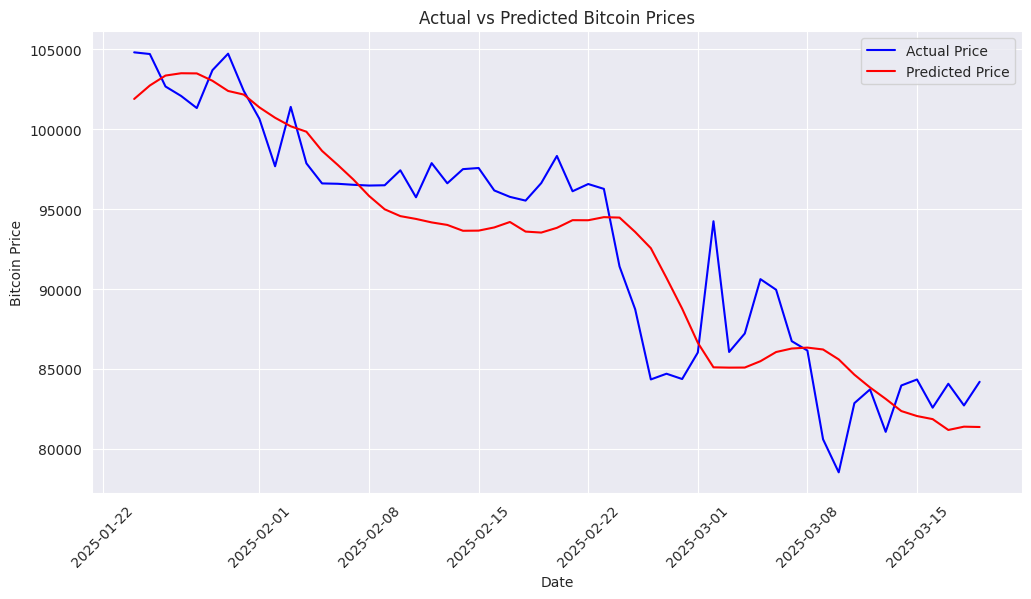

In [233]:
plt.figure(figsize=(12,6))
plt.plot(df_comparison["Date"], df_comparison["Actual Price"], label="Actual Price", color="blue")
plt.plot(df_comparison["Date"], df_comparison["Predicted Price"], label="Predicted Price", color="red")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.title("Actual vs Predicted Bitcoin Prices")
plt.show()

### Model Evaluation

In [234]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(df_comparison["Actual Price"], df_comparison["Predicted Price"])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_comparison["Actual Price"], df_comparison["Predicted Price"]))

# Calculate R² score
r2 = r2_score(df_comparison["Actual Price"], df_comparison["Predicted Price"])

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 2545.4007
Root Mean Squared Error (RMSE): 3205.6612
R² Score: 0.8115
